In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split

In [325]:
'''ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/movies.csv')
tags_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/tags.csv')
links_df = pd.read_csv('C:/Users/papad/Desktop/ml-latest-small/ml-latest-small/links.csv')'''

In [327]:
ratings_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/ratings.csv')
movies_df = pd.read_csv('C:/Users/papad/Desktop/ml-25m/ml-25m/movies.csv')

### Dataset

In [328]:
percentage = 3
movies_df = movies_df.head(int(len(movies_df)*(percentage/100)))

In [329]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
1867,1956,Ordinary People (1980),Drama
1868,1957,Chariots of Fire (1981),Drama
1869,1958,Terms of Endearment (1983),Comedy|Drama
1870,1959,Out of Africa (1985),Drama|Romance


In [330]:
ratings_df = ratings_df.head(int(len(ratings_df)*(percentage/100)))

In [331]:
ratings_df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
749997,5108,253,3.0,838458194
749998,5108,265,4.0,832662011
749999,5108,266,3.0,840782359
750000,5108,278,3.0,832661717


In [332]:
#ratings_df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [333]:
num_users = ratings_df['userId'].unique()
print(len(num_users))
num_items = ratings_df['movieId'].unique()
print(len(num_items))

5108
20111


# Spotlight

### Data preperation for Spotlight

The ids are not consecutive. For examples the id of a movies is shown multiple times. For this reason the procedure below is implemented. The reversed map is still saved to be used if needed.

In [334]:
from collections import defaultdict
from itertools import count

uid_map = defaultdict(count().__next__)
iid_map = defaultdict(count().__next__)
uids = np.array([uid_map[uid] for uid in ratings_df["userId"].values ], dtype=np.int32)
iids = np.array([iid_map[iid] for iid in ratings_df["movieId"].values ], dtype=np.int32)

uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}

ratings = ratings_df["rating"].values.astype(np.float32)
timestamps = ratings_df["timestamp"].values.astype(np.int32)

print("userId %d got uid %d" % (556, uid_map[556]))
print("movieId %d got iid %d" % (54001, iid_map[54001]))

userId 556 got uid 555
movieId 54001 got iid 557


Create the dataset variable representing the dataset prepared for use to create a recommendation systems using the Spotlight platform.

### Implicit Factorization model

In [335]:
from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  


#pecify the ids of the users and items for all the pairs of user-item interactions
implicit_interaction = Interactions(user_ids=uids,
                                   item_ids=iids)


#lets initialise the seed, so that its repeatable and reproducible 
implicit_train_tmp, implicit_test = random_train_test_split(implicit_interaction, random_state=np.random.seed(42))
#val split!
implicit_train, implicit_val = random_train_test_split(implicit_train_tmp, random_state=np.random.seed(42))

In [336]:
print(implicit_train)
print(implicit_test)
print(implicit_val)

<Interactions dataset (5108 users x 20111 items x 480000 interactions)>
<Interactions dataset (5108 users x 20111 items x 150001 interactions)>
<Interactions dataset (5108 users x 20111 items x 120001 interactions)>


### Train-test split to DataFrame

Train and test interaction datasets are converted to dataframes, in order to be used from other models too and provide consistent and fair results.

In [337]:
def interactionToDataFrame(dataset):
    converted_users = []
    converted_movies = []
    rating = []
    for i in range(len(dataset.user_ids)):
        converted_users.append(uid_rev_map[dataset.user_ids[i]])
        converted_movies.append(iid_rev_map[dataset.item_ids[i]])
        rating.append(float(ratings_df['rating'][(ratings_df['movieId']==converted_movies[i]) & (ratings_df['userId']==converted_users[i])].values))

    df = pd.DataFrame({'user_id':converted_users,'movie_id':converted_movies,'rating':rating})
    return df

In [338]:
'''train_df = interactionToDataFrame(implicit_train)
print('a')
val_df = interactionToDataFrame(implicit_val)
print('b')
test_df = interactionToDataFrame(implicit_test)'''

a
b


### Pickle 

Save

In [339]:
'''train_df.to_pickle("./train_df.pkl")
test_df.to_pickle("./test_df.pkl")
val_df.to_pickle("./val_df.pkl")'''

Load

In [340]:
train_df = pd.read_pickle("./train_df.pkl")
test_df = pd.read_pickle("./test_df.pkl")
val_df = pd.read_pickle("./val_df.pkl")

### Implicit Factorization model implementation

In [341]:
implicit_model  = ImplicitFactorizationModel(n_iter = 5)

current = time.time()

implicit_model.fit(implicit_train,verbose = True)

end = time.time()
diff = end - current
print('Training took %d second'%(diff))

Epoch 0: loss 0.40419354722499845
Epoch 1: loss 0.26937811131477357
Epoch 2: loss 0.243188095498085
Epoch 3: loss 0.2213677133957545
Epoch 4: loss 0.20551247171560924
Training took 534 second


MRR score of the Implicit recommender

In [342]:
from spotlight.evaluation import mrr_score
print(mrr_score(implicit_model, implicit_test, train=implicit_train, k=100).mean())

0.2086829124751359


Distribution of scores for a user

(array([2.000e+00, 7.000e+00, 1.900e+01, 3.000e+01, 7.200e+01, 1.430e+02,
        3.020e+02, 6.500e+02, 1.257e+03, 2.268e+03, 3.198e+03, 3.204e+03,
        2.479e+03, 1.480e+03, 9.720e+02, 5.960e+02, 4.390e+02, 3.980e+02,
        3.070e+02, 2.420e+02, 2.060e+02, 1.850e+02, 1.550e+02, 1.400e+02,
        1.800e+02, 1.870e+02, 1.790e+02, 1.790e+02, 1.470e+02, 1.250e+02,
        1.250e+02, 8.800e+01, 6.700e+01, 4.800e+01, 2.200e+01, 9.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([-23.808924  , -22.477737  , -21.146553  , -19.815367  ,
        -18.484182  , -17.152996  , -15.821812  , -14.490626  ,
        -13.159441  , -11.828256  , -10.49707   ,  -9.165884  ,
         -7.834699  ,  -6.503514  ,  -5.1723285 ,  -3.841143  ,
         -2.5099576 ,  -1.1787721 ,   0.15241328,   1.4835987 ,
          2.814784  ,   4.1459694 ,   5.4771547 ,   6.80834   ,
          8.139525  ,   9.470711  ,  10.801896  ,  12.133081  ,
         13.464267  ,  14.795452  ,  16.126638  ,  17.

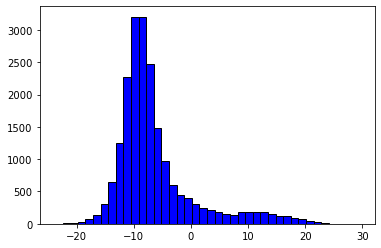

In [343]:
plt.hist(implicit_model.predict(0), color = 'blue', edgecolor = 'black',
         bins = 40)

Not a lot items with high score

### Top-K predictions for a user

In [344]:
import scipy.stats as st
k = 100
def topK_implicit(user, k=100):
  a= list()
  ranks = st.rankdata(-implicit_model.predict(user))   
  for iid in np.argwhere(ranks <= k):
    #print(iid_rev_map[iid.item(0)])
    a.append(iid_rev_map[iid.item(0)])
  return a

rec_forUser = topK_implicit(0)
print(rec_forUser)

[2012, 2692, 3949, 6016, 6377, 6539, 6711, 858, 1136, 1197, 1580, 2028, 2571, 2797, 3578, 3793, 4963, 4993, 5349, 6947, 7143, 8665, 8961, 33493, 40815, 778, 780, 1200, 1208, 1213, 1221, 1252, 2329, 3753, 3977, 4027, 4246, 4979, 5502, 5679, 5989, 6537, 6870, 6874, 7147, 7438, 8874, 27773, 27803, 31878, 48516, 48774, 48780, 50872, 54286, 54503, 55820, 58559, 59315, 59369, 68358, 69481, 69844, 70286, 72998, 79132, 81845, 91529, 106782, 109487, 122882, 122886, 2716, 5618, 8914, 44665, 68954, 1704, 750, 923, 1258, 1230, 2291, 2997, 3089, 4878, 46976, 3752, 82459, 1193, 26662, 31658, 4085, 26776, 31410, 46723, 38061, 6807, 3617, 7371]


The function below (allUsers_topK_implicit) returns a list that contains the top-K recommendations for each user.

In [345]:
def allUsers_topK_implicit():
    a = []
    for i in range(len(num_users)):
       a.append(topK_implicit(i))
    return a

In [346]:
movies_df.loc[movies_df['movieId'].isin(rec_forUser)]

,movieId,title,genres
734,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
762,778,Trainspotting (1996),Comedy|Crime|Drama
764,780,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller
840,858,"Godfather, The (1972)",Crime|Drama
902,923,Citizen Kane (1941),Drama|Mystery
1108,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
1164,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1167,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
1170,1200,Aliens (1986),Action|Adventure|Horror|Sci-Fi
1177,1208,Apocalypse Now (1979),Action|Drama|War


In [347]:
movies_pred = movies_df['movieId'][movies_df['movieId'].isin(rec_forUser)]

### Actual movies watched

In [348]:
actual = ratings_df[ratings_df["userId"]==uid_rev_map.get(0)].groupby("movieId")["movieId"].count().sort_values(ascending=False).head(100)

In [349]:
actual = actual.index.tolist()

In [350]:
movies_df.loc[movies_df['movieId'].isin(actual)]

,movieId,title,genres
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
302,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
303,307,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
654,665,Underground (1995),Comedy|Drama|War
878,899,Singin' in the Rain (1952),Comedy|Musical|Romance
1061,1088,Dirty Dancing (1987),Drama|Musical|Romance
1147,1175,Delicatessen (1991),Comedy|Drama|Romance
1186,1217,Ran (1985),Drama|War
1205,1237,"Seventh Seal, The (Sjunde inseglet, Det) (1957)",Drama
1217,1250,"Bridge on the River Kwai, The (1957)",Adventure|Drama|War


In [351]:
movies_watched = movies_df['movieId'][movies_df['movieId'].isin(actual)]

### NDCG Score for each user

In [352]:
allUsers_topK_implicit = allUsers_topK_implicit()

In [353]:
rec_forUser == allUsers_topK_implicit[0]

True

In [354]:
relevance_implicit = []
for i in range(len(rec_forUser)):
    if rec_forUser[i] in test_df['movie_id'][test_df['user_id'] == 1].values.tolist():
        relevance_implicit.append(1)
    else:
        relevance_implicit.append(0)
    

Compute the relevance for each user. The relevance containes 0s and 1s based on which movies each has watched. For every recommended movie that the user has actually watched, the value of 1 is assigned. There is a relevance list for each user.

In [355]:
relevance_implicit_full = []
helper = []
count = 0
for i in range(1,len(num_users)+1):
    for j in range(len(allUsers_topK_implicit[count])):
        if allUsers_topK_implicit[count][j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
            helper.append(1)
        else:
            helper.append(0)
    relevance_implicit_full.append(helper)
    helper = []
    count += 1

In [356]:
relevance_implicit == relevance_implicit_full[0]

True

The dcg and ideal_dcg functions are taken form https://github.com/lezzago/LambdaMart/blob/master/lambdamart.py. They are necessary to compute the desired NDCG evaluation metric.

In [357]:
def dcg(scores):
    """
    Returns the DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    DCG_val: int
        This is the value of the DCG on the given scores
    """
    return np.sum([
                    (np.power(2, scores[i]) - 1) / np.log2(i + 2)
                    for i in range(len(scores))
                ])

In [358]:
def ideal_dcg(scores):
    """
    Returns the Ideal DCG value of the list of scores.
    Parameters
    ----------
    scores : list
        Contains labels in a certain ranked order

    Returns
    -------
    Ideal_DCG_val: int
        This is the value of the Ideal DCG on the given scores
    """
    scores = [score for score in sorted(scores)[::-1]]
    return dcg(scores)

In [359]:
def NDCG_forUser(relevance):
    return dcg(relevance) / ideal_dcg(relevance)

In [360]:
ndcg = NDCG_forUser(relevance_implicit_full[0])
print(ndcg)
ndcg = NDCG_forUser(relevance_implicit)
print(ndcg)

0.45560514958746035
0.45560514958746035


Creation of a list (allUsers_implicit_ndcg) that contains the NDCG score for each user.

In [361]:
def allUsers_ndcg(relevance):
    allUsers_implicit_ndcg = []
    for i in range(len(num_users)):
        allUsers_implicit_ndcg.append(NDCG_forUser(relevance[i]))
    return allUsers_implicit_ndcg

In [362]:
allUsers_implicit_ndcg = allUsers_ndcg(relevance_implicit_full)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [410]:
len(allUsers_implicit_ndcg)

5108

# SVD

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [364]:
df_movie_features = train_df.pivot(
    index='user_id',
    columns='movie_id',
    values='rating'
).fillna(0)

In [365]:
df_movie_features

movie_id,1,2,3,4,5,6,7,8,9,10,...,207213,207309,207367,207405,207642,207830,207890,208080,208737,208939
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(df_movie_features, k = 10)


To get the prediction of a rating of an item dj, we can calculate the dot product of the two vectors.
The sigma variable has just the values, so I have to convert to a diagonal matrix in orded to implement the matrix multiplication.

In [367]:
sigma = np.diag(sigma)
svd_predictions_score = np.dot(np.dot(U, sigma), Vt)
svd_predictions_score_df = pd.DataFrame(svd_predictions_score, columns = df_movie_features.columns)


In [368]:
svd_predictions_score[0]

array([-0.02798734,  0.03043995, -0.10121945, ..., -0.00261803,
        0.00041197,  0.00194832])

In [369]:
svd_predictions_score_df.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,207213,207309,207367,207405,207642,207830,207890,208080,208737,208939
0,-0.027987,0.030440,-0.101219,-0.007476,-0.048354,-0.136987,-0.092261,-0.001249,-0.060567,0.003701,...,0.003973,-0.001923,-0.007428,-0.005942,-0.000895,-0.005942,-0.002204,-0.002618,0.000412,0.001948
1,1.862023,0.576335,0.029414,-0.070437,0.019996,-0.156554,0.171814,0.028677,-0.042392,0.514653,...,-0.009627,-0.006818,-0.010006,-0.008005,-0.001471,-0.008005,-0.001502,-0.009276,-0.001111,-0.007706
2,1.244702,1.265484,-0.338008,-0.088859,-0.130400,0.831281,-0.473512,0.004231,0.056472,0.584227,...,0.021815,0.007394,0.041731,0.033385,0.003659,0.033385,0.011263,0.036425,0.001245,0.032633
3,1.668102,0.396198,-0.040363,-0.023835,-0.039401,-0.003849,-0.041103,0.000848,-0.002127,0.059356,...,0.006193,0.009441,0.032295,0.025836,0.004757,0.025836,0.002801,0.001130,0.001013,0.006489
4,1.720130,0.757377,0.550393,0.091146,0.461160,0.752470,0.525827,0.042055,0.168931,1.063047,...,-0.000674,0.002067,0.003470,0.002776,0.000393,0.002776,0.000341,0.000155,0.000110,-0.003128


In [370]:
svd_predictions_score_df[svd_predictions_score_df.index == 0]

movie_id,1,2,3,4,5,6,7,8,9,10,...,207213,207309,207367,207405,207642,207830,207890,208080,208737,208939
0,-0.027987,0.03044,-0.101219,-0.007476,-0.048354,-0.136987,-0.092261,-0.001249,-0.060567,0.003701,...,0.003973,-0.001923,-0.007428,-0.005942,-0.000895,-0.005942,-0.002204,-0.002618,0.000412,0.001948


Code used from https://github.com/nikitaa30/Recommender-Systems/blob/master/matrix_factorisation_svd.py

Provide top-K predictions for a user

In [371]:
def recommend_movies(preds_df, userID, movies_df, original_ratings_df, num_recommendations):
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])]).merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left', left_on = 'movieId',
               right_on = 'movie_id').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [372]:
already_rated, predictions = recommend_movies(svd_predictions_score_df, 1, movies_df, ratings_df, 100)
already_rated.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
18,1,2632,5.0,1147878248,NaN,NaN
57,1,8327,5.0,1147879375,NaN,NaN
56,1,8154,5.0,1147868865,NaN,NaN
48,1,7361,5.0,1147880055,NaN,NaN


In [373]:
count = 0
for i in range(len(predictions)):
    if predictions['movieId'].values[i] in already_rated:
        coun+=1
print(count)

0


In [374]:
predictions.head()

,movieId,title,genres,movie_id
1168,1206,"Clockwork Orange, A (1971)",Crime|Drama|Sci-Fi|Thriller,1206.0
730,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,750.0
1654,1732,"Big Lebowski, The (1998)",Comedy|Crime,1732.0
758,778,Trainspotting (1996),Comedy|Crime|Drama,778.0
533,541,Blade Runner (1982),Action|Sci-Fi|Thriller,541.0


In [375]:
predicted_rank_svd = predictions['movieId'].values[0]
predicted_rank_svd

1206

The function SVD_topK_allUsers returens a list that contains the top-K recommendations for each user.

In [376]:
def SVD_topK_allUsers():
    allUsers_already_rated = []
    allUsers_predictions = []
    for i in range(1,len(num_users)+1):
        already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
        allUsers_already_rated.append(already_rated)
        allUsers_predictions.append(predictions)
    return allUsers_predictions

The function SVD_relevance returns a list that contains the relevance (0s and 1s) between the top-K recommendations and the movies that each user actually watched.

In [377]:
def SVD_relevance():
    svd_topK = SVD_topK_allUsers()
    relevance_svd_full = []
    helper = []
    count = 0
    for i in range(1,len(num_users)+1):
        for j in range(len(svd_topK[count])):
            if svd_topK[count]['movieId'].values[j] in test_df['movie_id'][test_df['user_id'] == i].values.tolist():
                helper.append(1)
            else:
                helper.append(0)
        relevance_svd_full.append(helper)
        helper = []
        count += 1
    return relevance_svd_full

In [378]:
svd_relevance = SVD_relevance()

In [379]:
allUsers_svd_ndcg = allUsers_ndcg(svd_relevance)

C:\Users\papad\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [380]:
allUsers_svd_ndcg[0]

nan

# LightGBM Baseline

I create 2 features, which are the scores from the Implicit and SVD models on the top-K recommendations for each user based on the implicit model.

In [381]:
target_movies = allUsers_topK_implicit
#for i in range(len(num_users)):
#    target_movies.append(topK_implicit(i))

### Feature 1 (Implicit model scores)

Map the target movies to pick the correct predictions based on the item id

In [382]:
map_target_movies = []
map_help = []
for movies in target_movies:
    for movie in movies:
        map_help.append(iid_map[movie])
    map_target_movies.append(map_help)
    map_help = []

Implicit Factorization model Scores

In [383]:
implicit_scores = []
feature1 = []
for i in range(len(num_users)):
    #for movies in map_target_movies:
    my_list = map_target_movies[i]
    my_array = np.array(my_list)
    implicit_scores.append(implicit_model.predict(user_ids = i,item_ids = my_array))
feature1.append(implicit_scores)
implicit_scores = []

In [384]:
feature1 = np.asarray(feature1).reshape(len(num_users),100)

### Feature 2 (SVD scores)

SVD model Scores. Take advantage of the DataFrame containing the scores to extract the predicted scores for the desired movies.

In [385]:
feature2 = []
helper = []
for i in range(len(num_users)):
    for movie in target_movies[i]:
        helper.append(svd_predictions_score_df[movie][i])
    feature2.append(helper)
    helper = []

In [386]:
features = np.stack((feature1,feature2))

Below are the movies that each user watched

In [387]:
def watched_movies(df):
    watched = []
    for i in range(len(num_users)):
        watched.append(df[df["user_id"]==uid_rev_map.get(i)].groupby("movie_id")["movie_id"].count().index)  
    return watched

In [388]:
train_watched = watched_movies(train_df)
test_watched = watched_movies(test_df)
val_watched = watched_movies(val_df)

Creation of the target list. It containes 0s and 1s for the 100 recommended movies for each user. Based on the watched movies it assigns the values. If the user watched the recommended movie, then the value of the target is equal to 1, otherwise it is 0.

In [389]:
def create_target(watched):
    user_target = []
    target = []
    for i in range(len(num_users)):
        for target_movie in target_movies[i]:
            if target_movie in watched[i]:
                user_target.append(1)
            else:
                user_target.append(0)
        target.append(user_target)
        user_target = []
    return target

In [390]:
y_train = create_target(train_watched)
y_test = create_target(test_watched)
y_val = create_target(val_watched)

In [391]:
X = np.array(features)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [392]:
X = X.reshape(len(num_users)*k, 2)
y_train = y_train.reshape(len(num_users)*k,)
y_test = y_train.reshape(len(num_users)*k,)
y_val = y_train.reshape(len(num_users)*k,)

In [393]:
import lightgbm as lgb
gbm = lgb.LGBMRanker()

target movies
train_df
feature1
feature2

In [394]:
'''X_train_feature1 = []
X_train_feature2 = []
for j in range(610):
    for i in range(len(target_movies[j])):
        if target_movies[j][i] in val_df['movie_id'].values.tolist():
            X_train_feature1.append(feature1[i])
            X_train_feature2.append(feature2[i])
print(X_train_feature1)
print(X_train_feature2)
#X_train = np.stack(X_train_feature1,X_train_feature2)'''

"X_train_feature1 = []\nX_train_feature2 = []\nfor j in range(610):\n    for i in range(len(target_movies[j])):\n        if target_movies[j][i] in val_df['movie_id'].values.tolist():\n            X_train_feature1.append(feature1[i])\n            X_train_feature2.append(feature2[i])\nprint(X_train_feature1)\nprint(X_train_feature2)\n#X_train = np.stack(X_train_feature1,X_train_feature2)"

X_train
X_test
X_val
y_train
y_test
y_val

In [395]:
X_train = X
X_test = X
X_val = X

In [396]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [397]:
query_train = [X_train.shape[0]]
query_val = [X_val.shape[0]]
query_test = [X_test.shape[0]]
group_train = []
group_val = []
print(query_train)
print(query_val)
print(query_test)
'''
for i in range(390):
    group_train.append(100)
group_train.append(40)
group_val.append(60)
for i in range(97):
    group_val.append(100)'''

for i in range(len(num_users)):
    group_train.append(k)
    group_val.append(k)


[510800]
[510800]
[510800]


In [398]:
gbm.fit(X_train, y_train, group=group_train,
        eval_set=[(X_val, y_val)], eval_group=[group_val],
        eval_at=[5, 10, 20], early_stopping_rounds=50)
#group – Group data of training data.

[1]	valid_0's ndcg@5: 0.223837	valid_0's ndcg@10: 0.231351	valid_0's ndcg@20: 0.261716
Training until validation scores don't improve for 50 rounds
[2]	valid_0's ndcg@5: 0.222909	valid_0's ndcg@10: 0.230946	valid_0's ndcg@20: 0.261991
[3]	valid_0's ndcg@5: 0.224064	valid_0's ndcg@10: 0.231181	valid_0's ndcg@20: 0.261487
[4]	valid_0's ndcg@5: 0.226032	valid_0's ndcg@10: 0.232287	valid_0's ndcg@20: 0.261153
[5]	valid_0's ndcg@5: 0.228273	valid_0's ndcg@10: 0.234153	valid_0's ndcg@20: 0.262158
[6]	valid_0's ndcg@5: 0.227058	valid_0's ndcg@10: 0.233883	valid_0's ndcg@20: 0.26127
[7]	valid_0's ndcg@5: 0.2231	valid_0's ndcg@10: 0.229734	valid_0's ndcg@20: 0.257127
[8]	valid_0's ndcg@5: 0.224325	valid_0's ndcg@10: 0.230314	valid_0's ndcg@20: 0.255392
[9]	valid_0's ndcg@5: 0.226897	valid_0's ndcg@10: 0.2324	valid_0's ndcg@20: 0.257587
[10]	valid_0's ndcg@5: 0.226642	valid_0's ndcg@10: 0.232015	valid_0's ndcg@20: 0.257299
[11]	valid_0's ndcg@5: 0.229345	valid_0's ndcg@10: 0.234472	valid_0's ndc

[94]	valid_0's ndcg@5: 0.270486	valid_0's ndcg@10: 0.272337	valid_0's ndcg@20: 0.296125
[95]	valid_0's ndcg@5: 0.270557	valid_0's ndcg@10: 0.272606	valid_0's ndcg@20: 0.296397
[96]	valid_0's ndcg@5: 0.270378	valid_0's ndcg@10: 0.27265	valid_0's ndcg@20: 0.296614
[97]	valid_0's ndcg@5: 0.270732	valid_0's ndcg@10: 0.272948	valid_0's ndcg@20: 0.297184
[98]	valid_0's ndcg@5: 0.270991	valid_0's ndcg@10: 0.273185	valid_0's ndcg@20: 0.297544
[99]	valid_0's ndcg@5: 0.271137	valid_0's ndcg@10: 0.273716	valid_0's ndcg@20: 0.297893
[100]	valid_0's ndcg@5: 0.271618	valid_0's ndcg@10: 0.273897	valid_0's ndcg@20: 0.298072
Did not meet early stopping. Best iteration is:
[100]	valid_0's ndcg@5: 0.271618	valid_0's ndcg@10: 0.273897	valid_0's ndcg@20: 0.298072


LGBMRanker()

In [399]:
test_pred = gbm.predict(X_test)

In [400]:
test_pred

array([ 0.00294499,  0.01110706,  0.00294499, ..., -0.08624133,
       -0.04592431, -0.17600929])

In [426]:
len(test_pred)

510800

In [428]:
count = 0
lightGBM_NDCG = []
h = 1
for i in range(len(num_users)):
    lightGBM_NDCG.append(NDCG_forUser(test_pred[count:k*h]))
    count += k
    h += 1

# NDCG Comparison

In [429]:
len(allUsers_svd_ndcg)

5108

In [430]:
ndcg_df = pd.DataFrame({'Implicit FM': allUsers_implicit_ndcg , 'SVD': allUsers_svd_ndcg , 'LightGBM': lightGBM_NDCG})

In [431]:
ndcg_df

,Implicit FM,SVD,LightGBM
0,0.455605,NaN,-18.292988
1,0.292583,NaN,-0.138789
2,0.417251,NaN,0.119717
3,0.440821,NaN,-0.066100
4,0.724153,NaN,-0.877637
...,...,...,...
5103,0.400460,NaN,1.550534
5104,0.477676,NaN,1.700830
5105,0.344530,NaN,1.585936
5106,0.445887,NaN,2.249395


# Draft

In [ ]:
from sklearn.metrics import dcg_score
true = np.asarray([actual])
pred = np.asarray([predicted_rank_svd])
dcg = dcg_score(true,pred)
idcg = dcg_score(true,true)
ndcg = dcg/idcg

In [ ]:
ndcg

In [ ]:
from sklearn.metrics import ndcg_score
n = ndcg_score(true,pred)
n

In [ ]:
'''relevance = []
for i in range(20,40):
    if predicted_rank_svd[i] in actual:
        relevance.append(1)
    else:
        relevance.append(0)'''

In [281]:
svd_rank_allUsers = []
for i in range(1,len(num_users)+1):
    already_rated, predictions = recommend_movies(svd_predictions_score_df, i, movies_df, ratings_df, 100)
    svd_rank_allUsers.append(predictions['movieId'].index.tolist()) 


In [ ]:
'''def NDCG_forUser_SVD(user):
    return dcg(svd_predictions[svd_predictions_df.index == user]) / ideal_dcg(svd_predictions[svd_predictions_df.index == user])'''

In [ ]:
'''NDCG_SVD = NDCG_forUser_SVD(2)'''

In [ ]:
'''NDCG_SVD'''

Take as features the predicted ratings for the users of SVD and Implicit for the next step?

### Embeddings 

In [ ]:
emb = implicit_model._net.item_embeddings.weight[9723]
emb = emb.tolist()
print(len(emb))

In [ ]:
#Input
#svd_predictions_score
#predicted_rank_svd
#emb
#l_rec (rank recommendations)

In [ ]:
svd_predictions_score.shape


In [ ]:
import lightgbm as lgb
gbm = lgb.LGBMRanker()

In [ ]:
from sklearn.model_selection import train_test_split

# KNN

Pivot is used to have a matrix that has as rows the userIDs and as columns the movieIDs. The unrated, by a user, movies are assigned the value 0 instead of null. Pivot organizes a DataFrame by giving index and column values. It is helpful in the recommender systems approach.

In [ ]:
df_movie_features = ratings_df.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

In [ ]:
df_movie_features

In [ ]:
height = [len(df_movie_features.values[df_movie_features.values== 0]),len(df_movie_features.values[df_movie_features.values==0.5]),
          len(df_movie_features.values[df_movie_features.values== 1]),len(df_movie_features.values[df_movie_features.values==1.5]),
          len(df_movie_features.values[df_movie_features.values== 2]),len(df_movie_features.values[df_movie_features.values==2.5]),
          len(df_movie_features.values[df_movie_features.values== 3]),len(df_movie_features.values[df_movie_features.values==3.5]),
          len(df_movie_features.values[df_movie_features.values== 4]),len(df_movie_features.values[df_movie_features.values==4.5]),
          len(df_movie_features.values[df_movie_features.values== 5])]
x = ('0','0.5', '1','1.5' ,'2','2.5', '3','3.5', '4','4.5','5')
plt.bar(x, height)
plt.xlabel('Rating')
plt.ylabel('Number of users')
plt.show()


A lot of ratings in the user-movie matrix are zero, so the data are extremely sparse.

To makes sesne the idea of obtaining the taste of the users, they should have rated at least 20 movies. Otherwise, the taste of them is not clear. The users that have rated less than 20 movies will be excluded. Also the movies that have less than 20 ratings will be excluded too.

In [ ]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)
# filter data to come to an approximation of user likings.
ratings_thres = 20
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(ratings_df)

In [ ]:
ratings_df[24400:24450]